United States market

Price to Cash flow from 10 to 20

In [195]:
import sys

import pandas
import sklearn
import sklearn.tree
import sklearn.cluster
import sklearn.preprocessing

sys.path.append('investpy')

import investpy
import random
import numpy as np
import scipy
import scipy.stats
import pandas_ta
import traceback

In [196]:
n = 50
index = 'NASDAQ'
country = "United States"
date_from = "01/09/2019"
date_to = "01/09/2020"

In [197]:
index_data = investpy.indices.get_index_historical_data(index, country, date_from, date_to)
correct_days = len(index_data)
print(f"Days in period: {correct_days}")

Days in period: 253


In [198]:
class StockData:
  def calculate_rsi(self, periods = 14, ema = True):
    close_delta = self.data.loc[:, 'Close'].diff()

    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)

    if ema:
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

  def calculate_info(self):
    self.average = self.close.mean()
    self.abs_growth = self.close[-1] - self.close[0]
    self.rel_growth = self.abs_growth/self.close[0]
    self.abs_growth_to_rel_growth = self.abs_growth/self.rel_growth
    self.variance = self.close.std() / self.average
    self.range = self.close.max() - self.close.min()
    self.range_ln = np.log(self.range)
    self.oscillation = self.average / self.range

    self.stock_diff = np.array([(self.close[i]/self.close[i-1])-1 for i in range(1, len(self.close))])
    self.profit_avg = self.stock_diff.mean()
    self.profit_var = self.stock_diff.std()

    self.ratios = investpy.stocks.get_stock_ratios(self.stock, self.country)

    self.debt_to_equity = self.ratios["Total Debt to Equity"].to_numpy()[0]
    if np.isnan(self.debt_to_equity):
        raise ValueError("Debt to equity is nan")

    self.basic_eps = self.ratios["Basic EPS"].to_numpy()[0]
    if np.isnan(self.basic_eps):
        raise ValueError("Basic EPS is nan")

    self.pe_ratio = self.ratios["P/E Ratio"].to_numpy()[0]
    if np.isnan(self.pe_ratio):
        raise ValueError("Basic EPS is nan")


    self.rsi = pandas_ta.rsi(self.data['Close'], length = correct_days-1).iloc[-1]
    self.volatility = self.close.std()

    # index_data.loc[:, 'Close'].to_numpy()

    self.spearman = scipy.stats.spearmanr(self.close, list(range(len(self.close)))).correlation
    # stability of quotes to2810.xlsx candles (22)
    # делаем линейную регрессию, считаем квадраты отклонений от неё, stability of quoates = 1 - среднеквадратичное отклонение / сумму квадратов отклонений

    # stability = среднее положительных приростов / среднеее отрицательных приростов
    # rsi = количество положительных приростов / количество отрицательных приростов

  def __init__(self, stock, country, date_from, date_to, data):
    self.stock = stock
    self.country = country
    self.date_from = date_from
    self.date_to = date_to
    self.data = data
    self.close = data.loc[:, 'Close'].to_numpy()
    self.calculate_info()

  def __repr__(self):
    return f"""
stock: {self.stock},
country: {self.country},
date_from: {self.date_from},
date_to: {self.date_to},
data: 
{self.data.head()}"""

In [199]:
def get_stock_historical_data(stock,
                              country,
                              from_date,
                              to_date):
  df = investpy.get_stock_historical_data(stock=stock,
                                          country=country,
                                          from_date=from_date,
                                          to_date=to_date,
                                          order='ascending',
                                          interval="Daily")
  return df.loc[:, ['Open', 'High', 'Low', 'Close']]

In [200]:
def get_random_stock_data_n(n, countries, date_from, date_to, correct_days, debug=False):
  stocks = []
  for country in countries:
    country_stocks = investpy.get_stocks_list(country)
    country_stocks = list(filter(lambda s: not s.endswith("_p"), country_stocks)) # _p is privileged stock
    country_stocks = zip(country_stocks, [country] * len(country_stocks))
    stocks += country_stocks
  random.shuffle(stocks)
  stock_data = []
  for (stock, country) in stocks:
    try:
      data = get_stock_historical_data(stock, country, date_from, date_to)
      stock_datum = StockData(stock, country, date_from, date_to, data)
      if len(stock_datum.close) != correct_days:
        continue
#       if stock_datum.profit_avg < 0:
#         continue
      stock_data.append(stock_datum)
    except Exception as e:
      if debug:
          traceback.print_exc()
        # print(e)
      # possibly, not available in selected date interval
    if len(stock_data) >= n:
      break
  return stock_data

In [201]:
def get_screener_stock_data_n(n, selected_stocks, country, date_from, date_to, correct_days, debug=False):
    stock_data = []
    for stock in selected_stocks:
        try:
            data = get_stock_historical_data(stock, country, date_from, date_to)
            if len(data.loc[:, 'Close']) != correct_days:
                continue
            stock_datum = StockData(stock, country, date_from, date_to, data)
            stock_data.append(stock_datum)
        except Exception as e:
            if debug:
                traceback.print_exc()
            # possibly, not available in selected date interval
        if len(stock_data) >= n:
            break
    return stock_data

In [202]:
def get_stock_data(method: str = 'screener', debug=False):
    if method == 'random':
        stock_data = get_random_stock_data_n(n, [country], date_from, date_to, correct_days, debug=debug)
    elif method == 'screener':
        selected_stocks_df = investpy.screener(
            investpy.ScreenerParams()
                .with_country(country)
                .add_filter("Price to Cash Flow (MRQ)", 10, 20),
            as_dataframe=True, n_results=100)
        selected_stocks = selected_stocks_df['symbol'].to_numpy()
        selected_stocks = list(set(selected_stocks))
        stock_data = get_screener_stock_data_n(n, selected_stocks, country, date_from, date_to, correct_days, debug=debug)
    else:
        raise ValueError(f"Unexpected method {method}")
    print(f"Selected {len(stock_data)} stocks: {list(map(lambda x: x.stock, stock_data))}")

    return stock_data

In [203]:
stock_data = get_stock_data('screener', debug=True)

Traceback (most recent call last):
  File "/tmp/ipykernel_18811/1349904557.py", line 8, in get_screener_stock_data_n
    stock_datum = StockData(stock, country, date_from, date_to, data)
  File "/tmp/ipykernel_18811/823113880.py", line 67, in __init__
    self.calculate_info()
  File "/tmp/ipykernel_18811/823113880.py", line 44, in calculate_info
    if np.isnan(self.pe_ratio):
TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
Traceback (most recent call last):
  File "/tmp/ipykernel_18811/1349904557.py", line 5, in get_screener_stock_data_n
    data = get_stock_historical_data(stock, country, date_from, date_to)
  File "/tmp/ipykernel_18811/1530837794.py", line 5, in get_stock_historical_data
    df = investpy.get_stock_historical_data(stock=stock,
  File "/home/yourass/Desktop/proga/hse21/hse_subj/finances/sem3/hw01/investpy/investpy/stocks.py", line 519, in get_stock_hi

Selected 48 stocks: ['HMC', 'FOXA', 'TELNY', 'HDB', 'ACCO', 'AIR', 'BUD', 'RDSa', 'BRDCY', 'HCMLY', 'NWSA', 'ATGE', 'ATHM', 'RDSb', 'CRH', 'ERIC', 'BBL', 'ADUS', 'ADTN', 'TAK', 'ALG', 'ABTX', 'CEO', 'AGNC', 'BTI', 'AOSL', 'IBA', 'CENTA', 'ACNB', 'VALE', 'HNNA', 'AMTB', 'ACIW', 'Y', 'AEIS', 'AJRD', 'ADRNY', 'AGCO', 'BABA', 'ACHC', 'CTSH', 'FLWS', 'NTTYY', 'BHP', 'TS', 'JOBS', 'GFI', 'EC']


In [204]:
print(stock_data[0].spearman)

-0.4619290365307948


In [298]:
from scipy.optimize import Bounds, minimize
import numpy as np
import matplotlib.pyplot as plt

labels =      list(map(lambda x: x.stock, stock_data))
mu = np.array(list(map(lambda x: 100*x.profit_avg, stock_data)))

var = np.array(list(map(lambda x: x.profit_var, stock_data)))

R = np.corrcoef(np.array(list(map(lambda x: x.stock_diff, stock_data))))

var = np.expand_dims(var, axis=0)
S = var.T @ var * R
# Initial guess
x = np.ones(len(labels)) * (1/len(labels))

def value(x):
        return x.T @ S @ x

def optimize_portfolio(r):
    mu_cons = {'type': 'eq',
                 'fun': lambda x: np.sum(mu @ x.T) - r
                }
    sum_cons = {'type': 'eq',
                 'fun': lambda x: np.sum(x) - 1
                }
    bnds = Bounds (np.ones_like(x) * 0.0, np.ones_like(x))

    res = minimize(value, x, method='SLSQP', 
                   constraints=[mu_cons, sum_cons], bounds=bnds)
    return res

rate = np.linspace(0, 1, 100)
opti = list(map(optimize_portfolio, rate))
y = np.array(list(map(lambda res: res.x, opti))).T

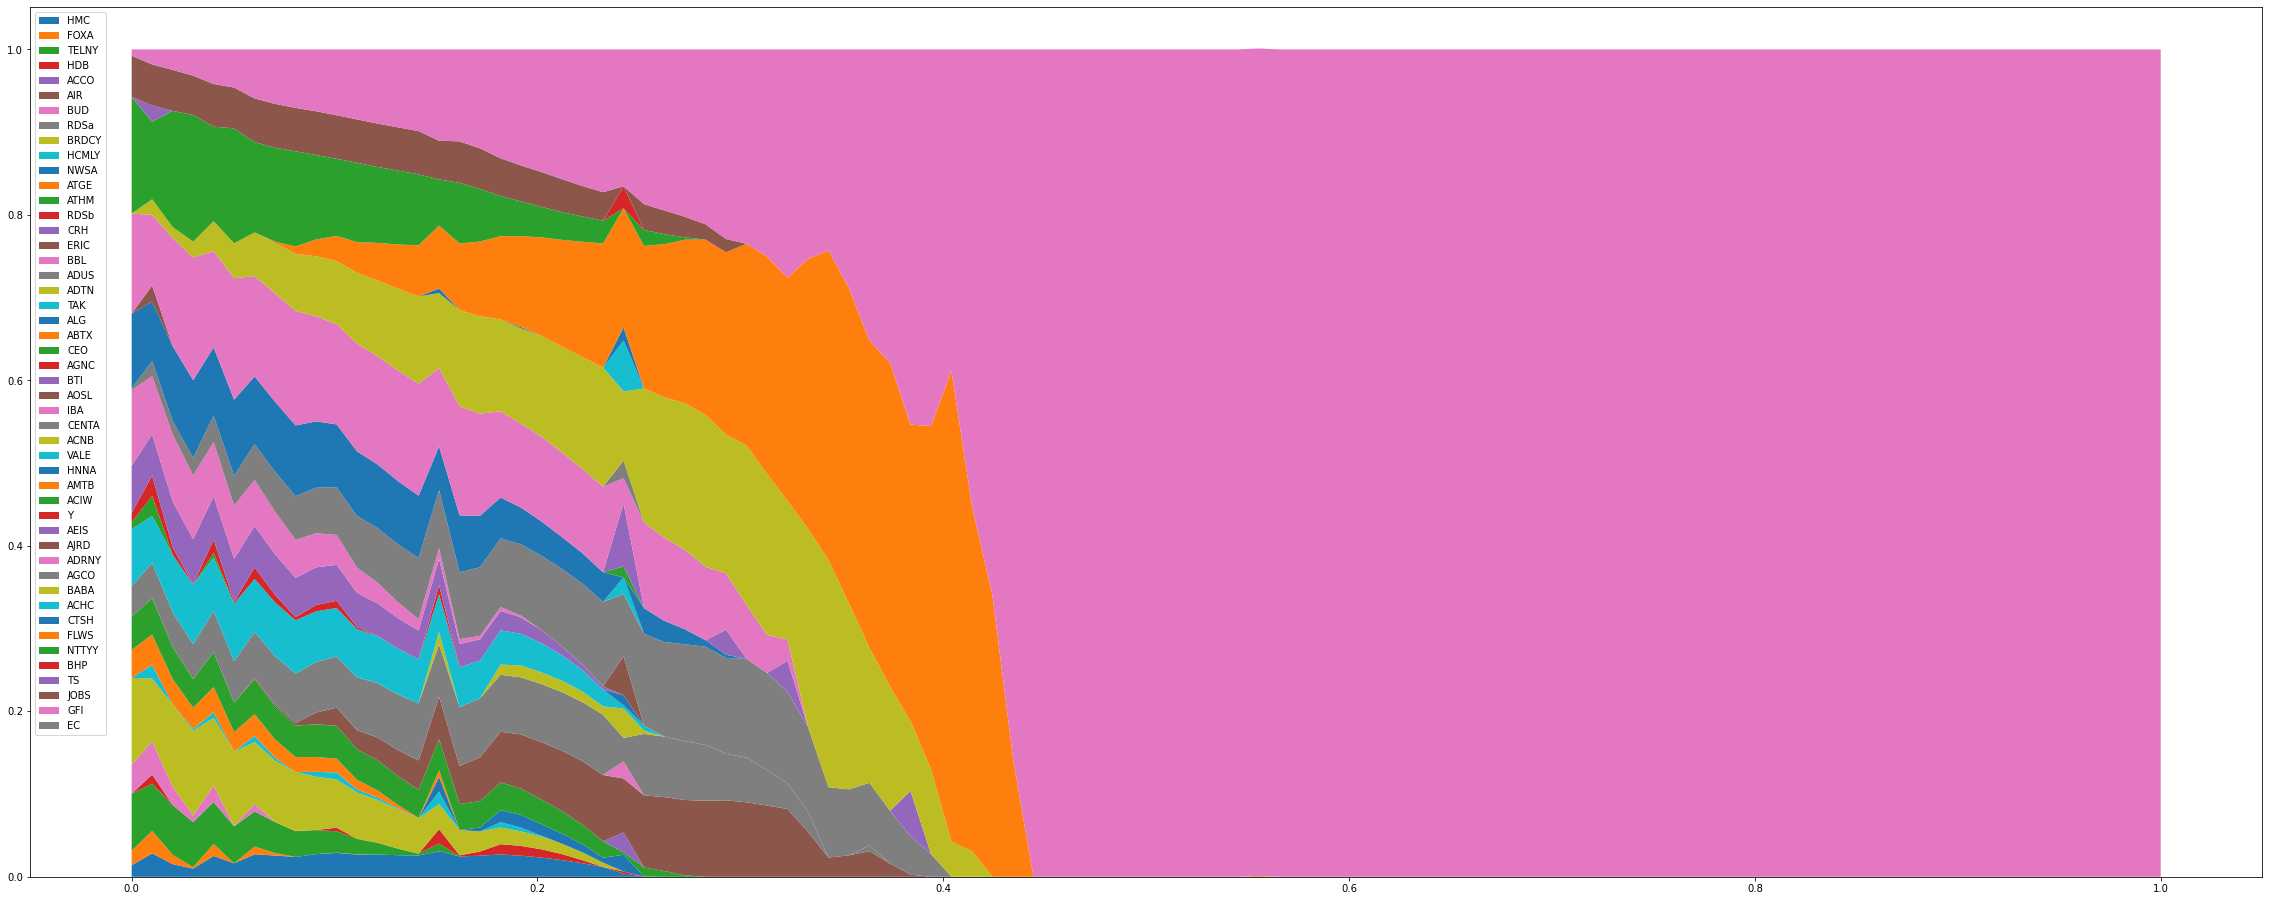

In [299]:
plt.figure(figsize=(40, 16))
plt.stackplot(rate, y, labels=labels)
plt.legend(loc='upper left')
plt.show()

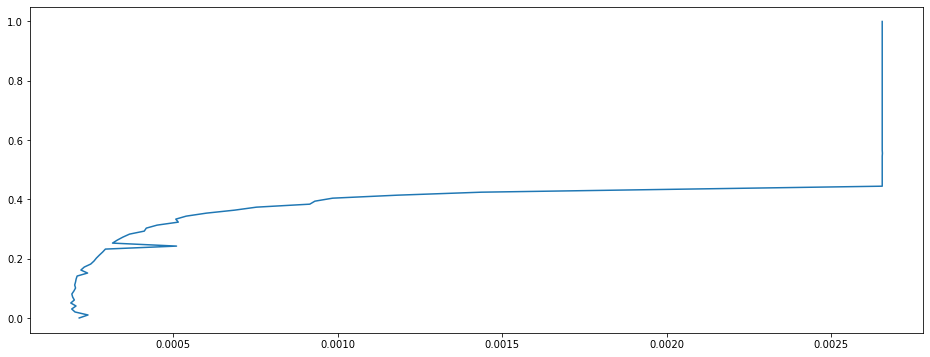

In [207]:
opti_vars = list(map(lambda res: res.fun, opti))
plt.figure(figsize=(16, 6))
plt.plot(opti_vars, rate)
plt.show()

In [208]:
def to_ndarray(stock_data):
    features = []
    features.append(list(map(lambda x: x.rsi, stock_data)))
    features.append(list(map(lambda x: x.volatility, stock_data)))
    features.append(list(map(lambda x: x.oscillation, stock_data)))
    features.append(list(map(lambda x: x.debt_to_equity, stock_data)))
    # features.append(list(map(lambda x: x.spearman, stock_data)))
    # features.append(list(map(lambda x: x.basic_eps, stock_data)))
    features.append(list(map(lambda x: x.pe_ratio, stock_data)))
    return np.array(features).T

In [209]:
stock_data_features = to_ndarray(stock_data)

In [210]:
def get_correlation(data, high_coef=0.8):
    coercoef = np.corrcoef(data.T)
    for (i, row) in enumerate(coercoef):
        for (j, val) in enumerate(row):
            if i < j and abs(val) >= high_coef:
                print('High correlation detected for features {} and {}'.format(i, j))
    return coercoef

In [211]:
get_correlation(stock_data_features)

array([[ 1.        , -0.13289815,  0.02311187, -0.09082063, -0.0130382 ],
       [-0.13289815,  1.        , -0.0651607 , -0.12724832, -0.08242592],
       [ 0.02311187, -0.0651607 ,  1.        ,  0.14379027, -0.12911127],
       [-0.09082063, -0.12724832,  0.14379027,  1.        , -0.11304799],
       [-0.0130382 , -0.08242592, -0.12911127, -0.11304799,  1.        ]])

In [218]:
sc = sklearn.preprocessing.StandardScaler()
sc.fit(stock_data_features)
stock_data_features_normalized = sc.transform(stock_data_features)

In [219]:
stock_data_features_normalized

array([[ 8.14240467e-02, -3.66759013e-01,  1.95372849e+00,
         9.28611153e-02, -1.15862885e+00],
       [-5.25783695e-01, -2.18100498e-01, -1.10384864e-01,
        -1.67915797e-02, -6.90869748e-01],
       [-5.73727917e-01, -3.79028408e-01,  7.77273812e-01,
         5.10787079e+00, -6.53584602e-01],
       [ 3.49489275e-02,  2.60153094e-03, -3.24237427e-01,
         8.18606696e-01,  3.02069707e+00],
       [-6.12418362e-01, -3.94168536e-01, -8.01253590e-01,
         8.26951946e-01, -7.17986218e-01],
       [-1.42655549e+00,  2.13229174e-01, -1.66718744e+00,
        -5.85141876e-01, -1.96841562e-01],
       [-1.25252007e+00,  5.25647643e-01, -1.09599335e+00,
         5.71742576e-01,  3.14240341e-03],
       [-1.85169999e+00,  2.00152857e-01, -9.46524857e-01,
        -1.32363580e-01,  1.25643175e+00],
       [-8.08336213e-01, -3.73447815e-01,  1.11936075e+00,
        -4.03196033e-01,  7.75961796e-01],
       [ 1.37558031e-01, -4.21933078e-01,  1.64983490e-01,
        -1.31781353e-01

In [214]:
print('KMeans')
for n_clusters in range(2, 10):
    kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters)
    kmeans.fit(stock_data_features_normalized)
    labels = kmeans.labels_
    print(n_clusters, sklearn.metrics.silhouette_score(stock_data_features_normalized, labels, metric='euclidean'))

KMeans
2 0.6157630784608251
3 0.19189981197641928
4 0.21614977164878457
5 0.24499150526271993
6 0.28612154025572895
7 0.2879886764672614
8 0.2870113160423558
9 0.276866995504143


In [215]:
for n_clusters in range(2, 10):
    agg = sklearn.cluster.AgglomerativeClustering(distance_threshold=None, n_clusters=n_clusters)
    agg.fit(stock_data_features_normalized)
    labels = agg.labels_
    print(n_clusters, sklearn.metrics.silhouette_score(stock_data_features_normalized, labels, metric='euclidean'))

2 0.6157630784608251
3 0.5104726092235911
4 0.19792980562369789
5 0.23229077003169984
6 0.27913226134058017
7 0.2843730942777975
8 0.28308695552041035
9 0.264550675770347


In [216]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

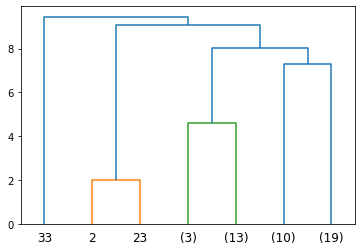

In [223]:
agg = sklearn.cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None)
agg.fit(stock_data_features_normalized)
plot_dendrogram(agg, truncate_mode='level', p=3)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [278]:
def draw_boxplot(X, labels, colors=None):
    # X[i] -- фичи для акции i
    # label[i] -- номер кластера акции i
    # X.shape = (#stocks, #features)

    fig, ax = plt.subplots(figsize=(10, 7))
    legend1, legend2 = [], []
    for label in range(1, max(labels) + 1):
        my = X[np.where(labels == label)]
        if colors is None:
            clr = list(np.random.random(3))
            clr2 = list(np.random.random(3))
        else:
            clr  = colors[label-1][0]
            clr2 = colors[label-1][1]
        bp = ax.boxplot(my, patch_artist=True)
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color=clr)
        for patch in bp['boxes']:
            patch.set(facecolor=clr2)
        legend1.append(bp["boxes"][0])
        legend2.append('Cluster ' + str(label-1))
    ax.legend(legend1, legend2)
    # plt.ylim(0, 1)
    plt.show()

In [307]:
def index_by_stock_data(stock_data_closes):
    # closes = []
    # for i in stock_data:
    #     closes.append(i.close)
    return scipy.stats.mstats.gmean(np.array(stock_data_closes))

In [295]:
index_by_stock_data(stock_data)

array([32.01785922, 32.25046404, 32.59995202, 32.58810693, 32.96143906,
       33.24621304, 33.64529769, 33.73389518, 33.76106638, 33.75281992,
       33.72142591, 33.62453392, 33.57350556, 33.56491418, 33.6010494 ,
       33.24908674, 33.50841643, 33.23580762, 33.07699996, 33.10086483,
       32.7000768 , 32.2826724 , 32.36248798, 32.62691868, 32.51993952,
       32.15686339, 32.41048413, 32.38831821, 32.86656844, 32.68385378,
       32.93716957, 32.97101039, 33.13408746, 32.84539697, 33.1237323 ,
       33.15373103, 33.32380665, 33.32326605, 33.26974384, 33.54537751,
       33.55475125, 33.29158535, 33.00218771, 33.49793809, 33.73254609,
       33.73577463, 33.5631242 , 33.74967275, 33.71563242, 33.75560095,
       33.7396228 , 33.6401258 , 33.53661596, 33.73853252, 33.64059095,
       33.68739156, 33.5745251 , 33.39585853, 33.5819371 , 34.02231592,
       33.99385431, 33.95743577, 33.73127458, 33.53044455, 33.27114263,
       33.54990805, 33.64929201, 33.96484357, 33.88967508, 33.88

In [334]:
from scipy.optimize import Bounds, minimize
import numpy as np
import matplotlib.pyplot as plt

def best_representative_of_cluster(stock_data, labels):
    # labels =      list(map(lambda x: x.stock, stock_data))
    # mu = np.array(list(map(lambda x: 100*x.profit_avg, stock_data)))
    #
    # var = np.array(list(map(lambda x: x.profit_var, stock_data)))
    #
    # R = np.corrcoef(np.array(list(map(lambda x: x.stock_diff, stock_data))))
    #
    # var = np.expand_dims(var, axis=0)
    # S = var.T @ var * R
    # Initial guess

    stock_data_closes = []
    for stock_datum in stock_data:
        stock_data_closes.append(stock_datum.close)
    stock_data_closes = np.array(stock_data_closes)

    best_of_cluster = []
    for label in range(1, max(labels)+1):
        global_indices = np.array(list(range(len(stock_data))))[np.where(labels == label)]
        stock_data_closes_in_cluster = stock_data_closes[np.where(labels == label)]
        # print(stock_data_closes_in_cluster.shape)
        print("Cluster {}: {}".format(label, ' '.join(np.array(list(map(lambda x: x.stock, stock_data)))[np.where(labels == label)])))

        index_in_cluster = index_by_stock_data(stock_data_closes_in_cluster)

        x = np.ones(len(stock_data_closes_in_cluster)) * (1/len(stock_data_closes_in_cluster))

        def value(x):
            # print(stock_data_closes_in_cluster.shape, x.shape, index_in_cluster.shape)
            return (stock_data_closes_in_cluster.T @ x - index_in_cluster).std()

        # def optimize_portfolio():
        sum_cons = {'type': 'eq',
                     'fun': lambda x: np.sum(x) - 1
                    }
        bnds = Bounds (np.zeros_like(x), np.ones_like(x))

        opti = minimize(value, x, method='SLSQP', constraints=[sum_cons], bounds=bnds)

        # rate = np.linspace(0, 1, 100)
        # opti = list(map(optimize_portfolio, rate))
        best_of_cluster.append((global_indices[np.argmax(opti.x)], np.max(opti.x)))
    return best_of_cluster

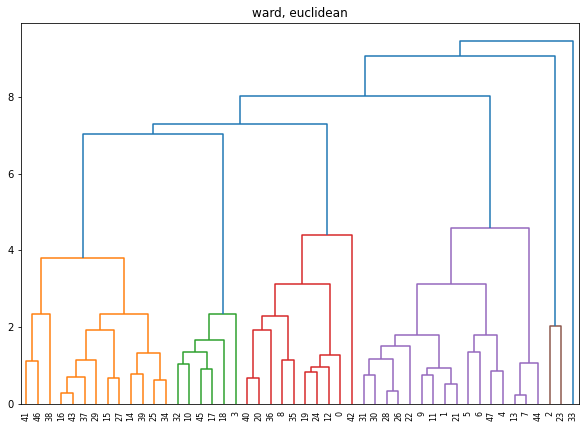

Method ward, Metric euclidean, Number of clusters 2, Silhouette 0.6157630784608251
Method ward, Metric euclidean, Number of clusters 3, Silhouette 0.5104726092235911
Method ward, Metric euclidean, Number of clusters 4, Silhouette 0.19792980562369789
Method ward, Metric euclidean, Number of clusters 5, Silhouette 0.23229077003169984
Method ward, Metric euclidean, Number of clusters 6, Silhouette 0.27913226134058017


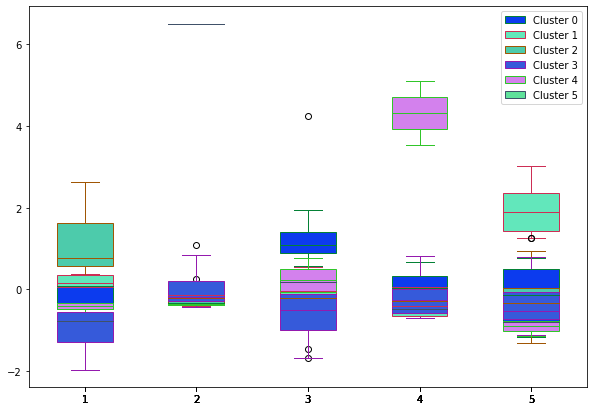

Cluster 1: HMC BRDCY ATHM TAK ALG BTI AJRD ADRNY CTSH NTTYY
Cluster 2: HDB NWSA ADUS ADTN ACIW JOBS
Cluster 3: CRH ERIC BBL AOSL CENTA VALE AEIS AGCO BABA ACHC FLWS BHP GFI
Cluster 4: FOXA ACCO AIR BUD RDSa HCMLY ATGE RDSb ABTX CEO IBA ACNB HNNA AMTB TS EC
Cluster 5: TELNY AGNC
Cluster 6: Y
Best representatives of clusters
Cluster 0: TAK with coefficient 0.18392237648004026
Cluster 1: ADTN with coefficient 0.3101762350684251
Cluster 2: GFI with coefficient 0.2503536161236085
Cluster 3: ACCO with coefficient 0.17108772667294478
Cluster 4: AGNC with coefficient 0.5263507153702661
Cluster 5: Y with coefficient 1.0


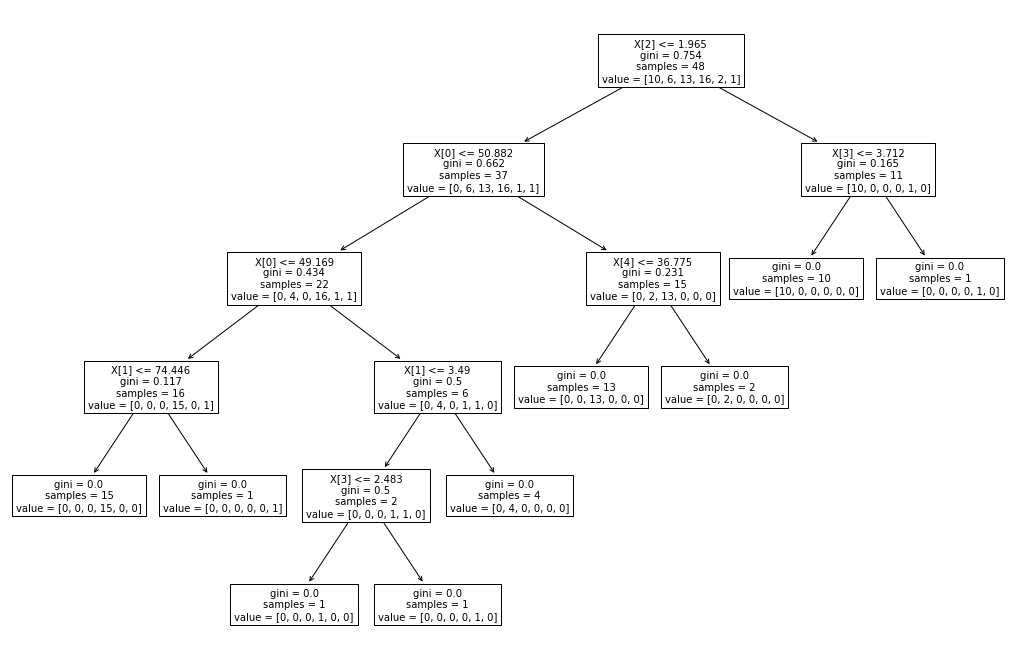

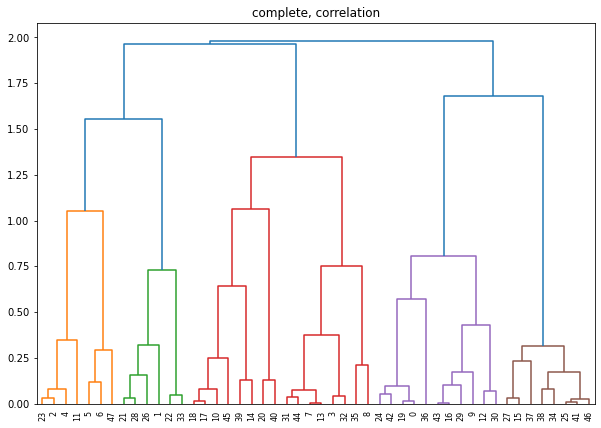

Method complete, Metric correlation, Number of clusters 2, Silhouette 0.343030014554957
Method complete, Metric correlation, Number of clusters 3, Silhouette 0.4187436600457417
Method complete, Metric correlation, Number of clusters 4, Silhouette 0.396872647539781
Method complete, Metric correlation, Number of clusters 5, Silhouette 0.4427589470055883
Method complete, Metric correlation, Number of clusters 6, Silhouette 0.43819557004882514


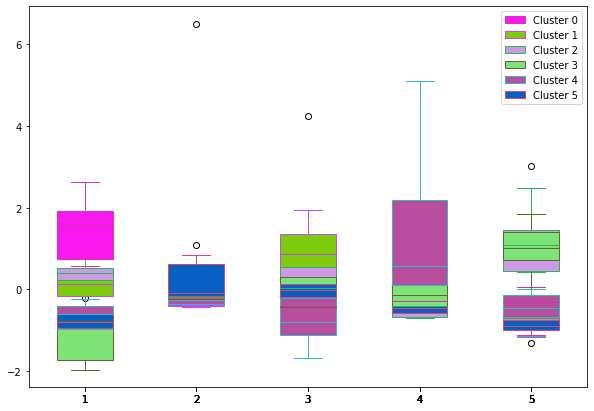

Cluster 1: ERIC AOSL CENTA AEIS AGCO BABA FLWS GFI
Cluster 2: HMC HCMLY ATHM BBL TAK BTI VALE HNNA ADRNY NTTYY BHP
Cluster 3: NWSA CRH ADUS ADTN ALG ACHC CTSH JOBS
Cluster 4: HDB RDSa BRDCY RDSb AMTB ACIW AJRD TS
Cluster 5: TELNY ACCO AIR BUD ATGE AGNC EC
Cluster 6: FOXA ABTX CEO IBA ACNB Y
Best representatives of clusters
Cluster 0: GFI with coefficient 0.29721936649434116
Cluster 1: HNNA with coefficient 0.25975270357865105
Cluster 2: ADTN with coefficient 0.3398150838785042
Cluster 3: TS with coefficient 0.22094188665967165
Cluster 4: ACCO with coefficient 0.2679258142140511
Cluster 5: FOXA with coefficient 0.24167309820955835


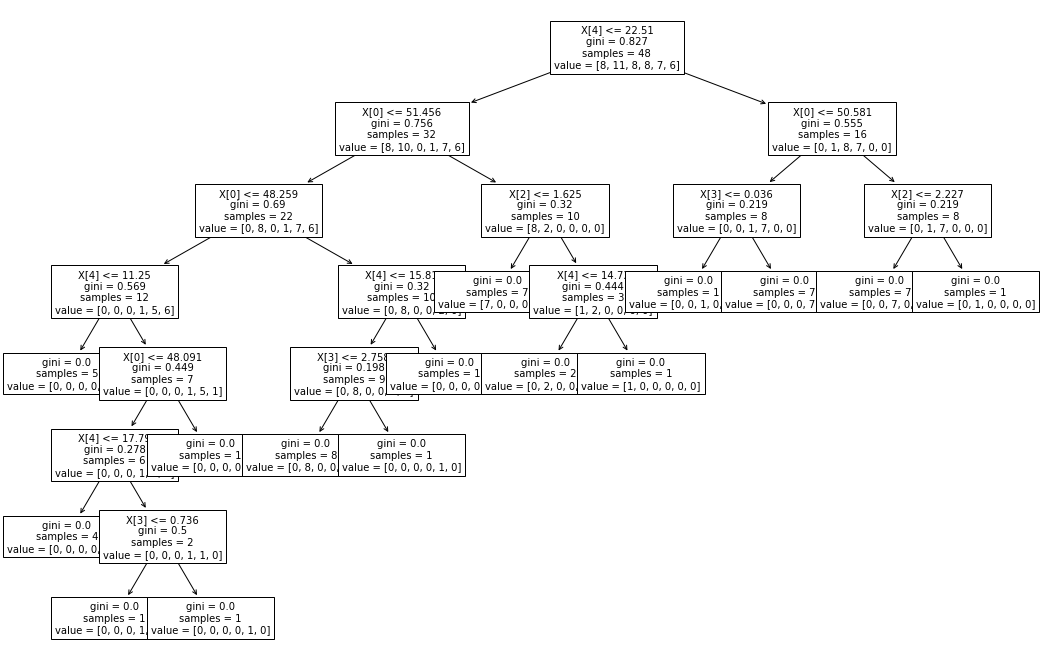

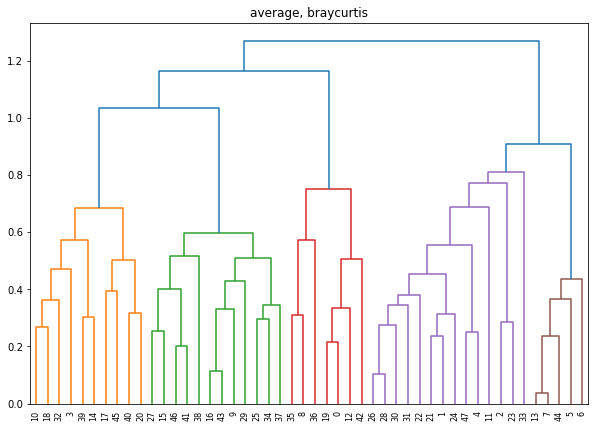

Method average, Metric braycurtis, Number of clusters 2, Silhouette 0.30728807945516373
Method average, Metric braycurtis, Number of clusters 3, Silhouette 0.27495937570148127
Method average, Metric braycurtis, Number of clusters 4, Silhouette 0.29810567633200163
Method average, Metric braycurtis, Number of clusters 5, Silhouette 0.30423709743000305
Method average, Metric braycurtis, Number of clusters 6, Silhouette 0.2946990599303128


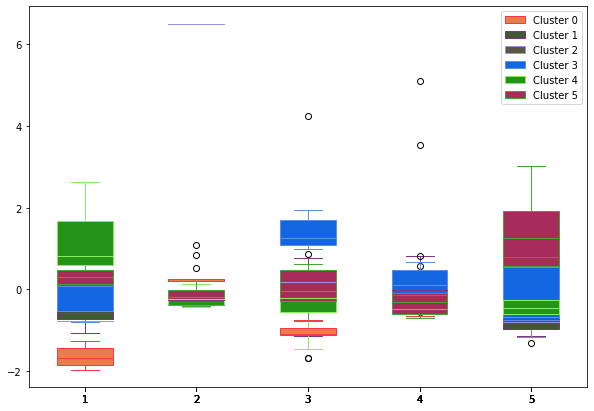

Cluster 1: AIR BUD RDSa RDSb TS
Cluster 2: FOXA TELNY ACCO ATGE ABTX CEO AGNC BTI IBA ACNB HNNA AMTB EC
Cluster 3: Y
Cluster 4: HMC BRDCY ATHM TAK AJRD ADRNY NTTYY
Cluster 5: HCMLY ERIC BBL AOSL CENTA VALE AEIS AGCO BABA FLWS BHP GFI
Cluster 6: HDB NWSA CRH ADUS ADTN ALG ACIW ACHC CTSH JOBS
Best representatives of clusters
Cluster 0: AIR with coefficient 0.27132190476327017
Cluster 1: ACCO with coefficient 0.1749869667534898
Cluster 2: Y with coefficient 1.0
Cluster 3: HMC with coefficient 0.21073474772175838
Cluster 4: GFI with coefficient 0.29709002717938576
Cluster 5: ADTN with coefficient 0.2682553881645969


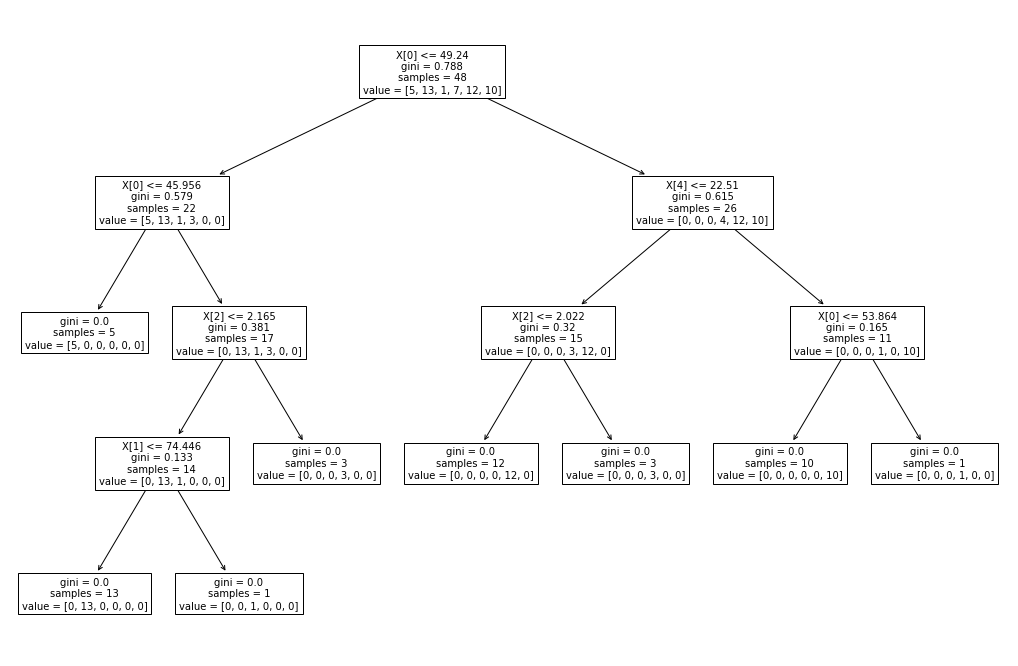

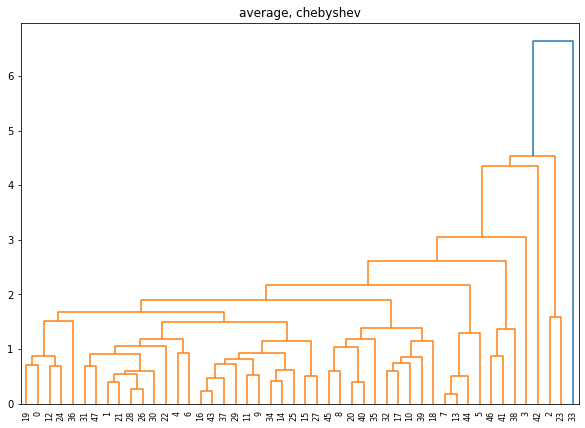

Method average, Metric chebyshev, Number of clusters 2, Silhouette 0.6572515367363665
Method average, Metric chebyshev, Number of clusters 3, Silhouette 0.5547847433511195
Method average, Metric chebyshev, Number of clusters 4, Silhouette 0.5179075346870896
Method average, Metric chebyshev, Number of clusters 5, Silhouette 0.3228531046884601
Method average, Metric chebyshev, Number of clusters 6, Silhouette 0.23539222313682515


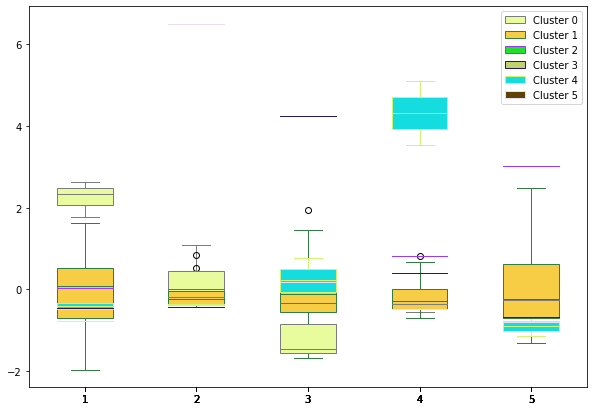

Cluster 1: BABA FLWS GFI
Cluster 2: HMC FOXA ACCO AIR BUD RDSa BRDCY HCMLY NWSA ATGE ATHM RDSb CRH ERIC BBL ADUS ADTN TAK ALG ABTX CEO BTI AOSL IBA CENTA ACNB VALE HNNA AMTB ACIW AEIS AJRD ADRNY AGCO ACHC CTSH BHP TS JOBS EC
Cluster 3: HDB
Cluster 4: NTTYY
Cluster 5: TELNY AGNC
Cluster 6: Y
Best representatives of clusters
Cluster 0: FLWS with coefficient 0.8624964151847458
Cluster 1: AOSL with coefficient 0.07464918929261698
Cluster 2: HDB with coefficient 1.0
Cluster 3: NTTYY with coefficient 1.0
Cluster 4: AGNC with coefficient 0.5263507153702661
Cluster 5: Y with coefficient 1.0
[[1.         0.48672295 0.67686067 0.38681273]
 [0.48672295 1.         0.60204485 0.25317651]
 [0.67686067 0.60204485 1.         0.27128252]
 [0.38681273 0.25317651 0.27128252 1.        ]]


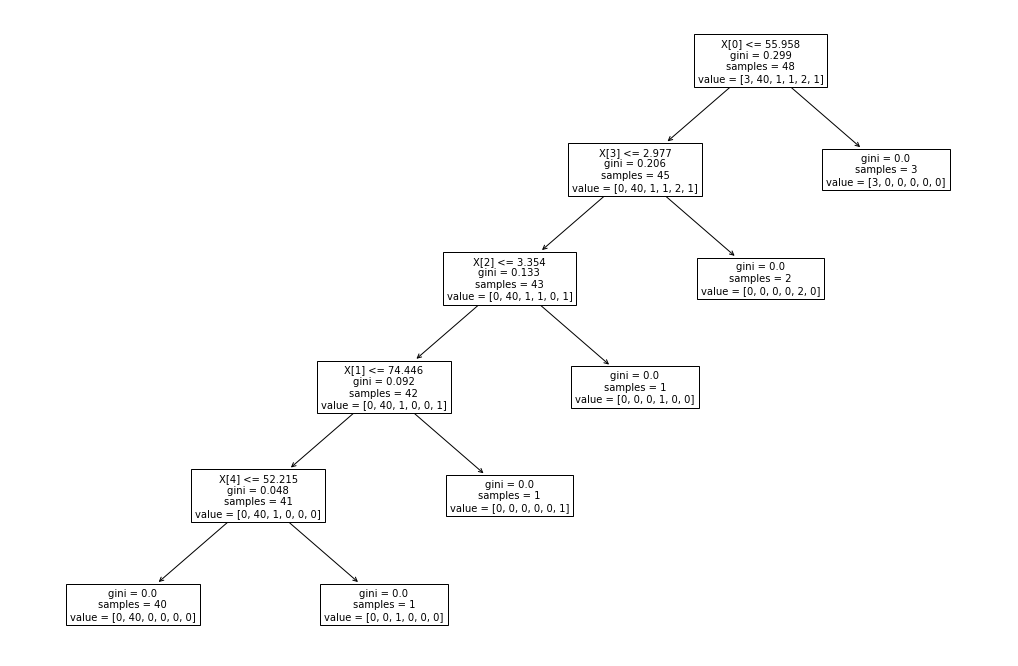

In [341]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

methods = ['single', 'ward', 'complete', 'average', 'weighted', 'centroid', 'median']
metrics =  ['braycurtis', 'canberra', 'chebyshev', 'cityblock',
            'correlation', 'cosine', 'dice', 'euclidean', 'hamming',
            'jaccard', 'jensenshannon', 'kulsinski', 'mahalanobis', 'matching',
            'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean',
            'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']

def labels_by_linked(linked, n_clusters):
    return scipy.cluster.hierarchy.fcluster(linked, t=n_clusters, criterion='maxclust')

all_labels = []

for (method, metric) in [('ward', 'euclidean'), ('complete', 'correlation'), ('average', 'braycurtis'), ('average', 'chebyshev')]:
    linked = linkage(stock_data_features_normalized, method=method, metric=metric, optimal_ordering=True)

    labelList = range(0, len(stock_data_features_normalized))

    plt.figure(figsize=(10, 7))
    dendrogram(linked,
                orientation='top',
                labels=labelList,
                distance_sort='descending',
                show_leaf_counts=True)
    plt.title('{}, {}'.format(method, metric))
    plt.show()

    for n_clusters in range(2, 7):
        labels = labels_by_linked(linked, n_clusters)
        silhouette = sklearn.metrics.silhouette_score(stock_data_features_normalized, labels, metric=metric)
        print('Method {}, Metric {}, Number of clusters {}, Silhouette {}'.format(method, metric, n_clusters, silhouette))

    labels = labels_by_linked(linked, 6)
    all_labels.append(labels)
    # colors = [('tan', 'red'), ('blue', 'black'), ('green', 'cyan')]
    draw_boxplot(stock_data_features_normalized, labels)
    tree = sklearn.tree.DecisionTreeClassifier()
    tree.fit(stock_data_features, labels)
    plt.figure(figsize=(18, 12))
    sklearn.tree.plot_tree(tree, fontsize=10)
    best_of_cluster = best_representative_of_cluster(stock_data, labels)
    print('Best representatives of clusters')
    for (label, (i, coef)) in enumerate(best_of_cluster):
        print('Cluster {}: {} with coefficient {}'.format(label, stock_data[i].stock, coef))

completeness_scores = np.zeros((len(all_labels), len(all_labels)))
for (i, l1) in enumerate(all_labels):
    for (j, l2) in enumerate(all_labels):
        completeness_scores[i][j] = sklearn.metrics.v_measure_score(l1, l2)
print(completeness_scores)

In [340]:
completeness_scores

array([[1.        , 0.45182257, 0.65510828, 0.61355808],
       [0.52746632, 1.        , 0.62985452, 0.44762563],
       [0.70010723, 0.57658708, 1.        , 0.4505456 ],
       [0.28243617, 0.17650327, 0.1940671 , 1.        ]])